In [194]:
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import yfinance as yf
import pandas as pd
import numpy as np
import os
import pandas_ta

plt.style.use('Solarize_Light2')

In [195]:
WINDOW = 21

n_low_col = f"{WINDOW}-Low"
n_high_col = f"{WINDOW}-High"
# n_ema_col = f"{WINDOW}-EMA"

In [196]:
if os.path.exists("data.csv"):
    df = pd.read_csv("data.csv", index_col=0)
else:
    gold_ticker = yf.Ticker("GC=F")
    df = gold_ticker.history(period="max", interval='1h')
    df.to_csv("data.csv")

df.index = pd.to_datetime(df.index, utc=True)

df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)
df.columns = df.columns.str.lower()

# display(df.shape)
# display(df.head(3))

In [197]:
df[n_low_col] = df['low'].rolling(window=WINDOW).min()
df[n_high_col] = df['high'].rolling(window=WINDOW).max()

# df[n_ema_col] = df['close'].rolling(window=WINDOW).mean()
# df["200-EMA"] = df['close'].ewm(span=200, adjust=False).mean()

# df['previous_close'] = df['close'].shift(1)

# Calculate True Range (TR)
df['TR1'] = df['high'] - df['low']
df['TR2'] = (df['high'] - df['close']).abs() # in case of gaps
df['TR3'] = (df['low'] - df['close']).abs() # in case of gaps

df['TR'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)

# Calculate the Average True Range (ATR)
df['ATR'] = df['TR'].rolling(window=WINDOW).mean()

df.dropna(inplace=True)

df[n_high_col] = df[n_high_col].shift(1)
df[n_low_col] = df[n_low_col].shift(1)
df['ATR'] = df['ATR'].shift(1)

df.head()

,open,high,low,close,21-Low,21-High,TR1,TR2,TR3,TR,ATR
Datetime,,,,,,,,,,,
2022-10-03 12:00:00+00:00,1674.099976,1678.199951,1671.900024,1673.599976,NaN,NaN,6.299927,4.599976,1.699951,6.299927,NaN
2022-10-03 13:00:00+00:00,1673.599976,1683.000000,1673.500000,1677.400024,1666.5,1683.199951,9.500000,5.599976,3.900024,9.500000,4.433321
2022-10-03 14:00:00+00:00,1677.400024,1700.400024,1677.400024,1695.800049,1666.5,1683.000000,23.000000,4.599976,18.400024,23.000000,4.680943
2022-10-03 15:00:00+00:00,1695.699951,1703.199951,1695.599976,1699.199951,1666.5,1700.400024,7.599976,4.000000,3.599976,7.599976,5.395229
2022-10-03 16:00:00+00:00,1699.199951,1702.000000,1696.400024,1699.900024,1666.5,1703.199951,5.599976,2.099976,3.500000,5.599976,5.509516


In [198]:
buy_filter = df['low'] < df[n_low_col]
sell_filter = df['high'] > df[n_high_col]

df['signal'] = 0.0  # Default to hold/no position
df.loc[buy_filter, 'signal'] = 1 # Buy signal
df.loc[sell_filter, 'signal'] = -1 # Sell signal

In [199]:
df['PnL'] = 0.0

is_trade_on = False

entry = 0.0
sl = 0.0
tp = 0.0

def trade_off():
    global is_trade_on
    global entry
    global sl
    global tp

    is_trade_on = False
    entry = 0.0
    sl = 0.0
    tp = 0.0

# Loop through candles and execute trades
for i, row in df.iterrows(): # row for reading, i for writing
    if is_trade_on:
        is_long = sl < entry
        if is_long:
            tp = row[n_high_col]
            if row['high'] > tp:
                df.loc[i, 'PnL'] = (tp - entry)/(entry - sl)
                trade_off()
            if row['low'] <= sl:
                df.loc[i, 'PnL'] = -1
                trade_off()
        else:
            tp = row[n_low_col]
            if row['low'] > tp:
                df.loc[i, 'PnL'] = (tp - entry)/(entry - sl)
                trade_off()
            if row['high'] >= sl:
                df.loc[i, 'PnL'] = -1
                trade_off()
    else:
        if row['signal'] == 1:
            is_trade_on = True
            entry = row[n_low_col]
            sl = entry - 2 * row['ATR']
            if row['low'] <= sl: # instant check
                df.loc[i, 'PnL'] = -1
                trade_off()

        if row['signal'] == -1:
            is_trade_on = True
            entry = row[n_high_col]
            sl = entry + 2 * row['ATR']
            if row['high'] >= sl: # instant check
                df.loc[i, 'PnL'] = -1
                trade_off()

In [200]:
# winners_count = df.loc[df['PnL'] > 0, 'PnL'].count()
# losers_count = df.loc[df['PnL'] < 0, 'PnL'].count()
# _losers_count = df.loc[df['PnL'] == -1, 'PnL'].count()
# losers_count, winners_count, _losers_count

df.loc[df['PnL'] < 0, 'PnL'].value_counts()

PnL
-1.0    913
Name: count, dtype: int64

In [201]:
# Calculate cumulative profit/loss
df['Cumulative_PnL'] = df['PnL'].cumsum()

# Filter rows where we had a trade exit
trades = df[df['PnL'] != 0]

# Summary statistics
total_trades = len(trades)
total_pnl = round(df['Cumulative_PnL'].iloc[-1])  # Total profit/loss
PnL = trades['PnL'].value_counts(normalize=True)
win_rate = 0

if not PnL.empty:
    win_rate = PnL[PnL.index > 0].iloc[0]

expectency = 0
# expectency = (RRR + 1) * win_rate - 1

strategy_stats_df = pd.DataFrame(
    np.array([[
        total_trades,
        total_pnl,
        round(win_rate * 100, 2),
        'RRR',
        expectency,
        expectency * total_trades
    ]]),
    columns=['Total Trades', 'Total Profit/Loss (RR)', 'Win rate (%)', 'Risk-Reward Ratio', 'Expectancy', 'Expected return'],
    index=['Metrics']
)

strategy_stats_df

,Total Trades,Total Profit/Loss (RR),Win rate (%),Risk-Reward Ratio,Expectancy,Expected return
Metrics,1048,-727,0.1,RRR,0,0


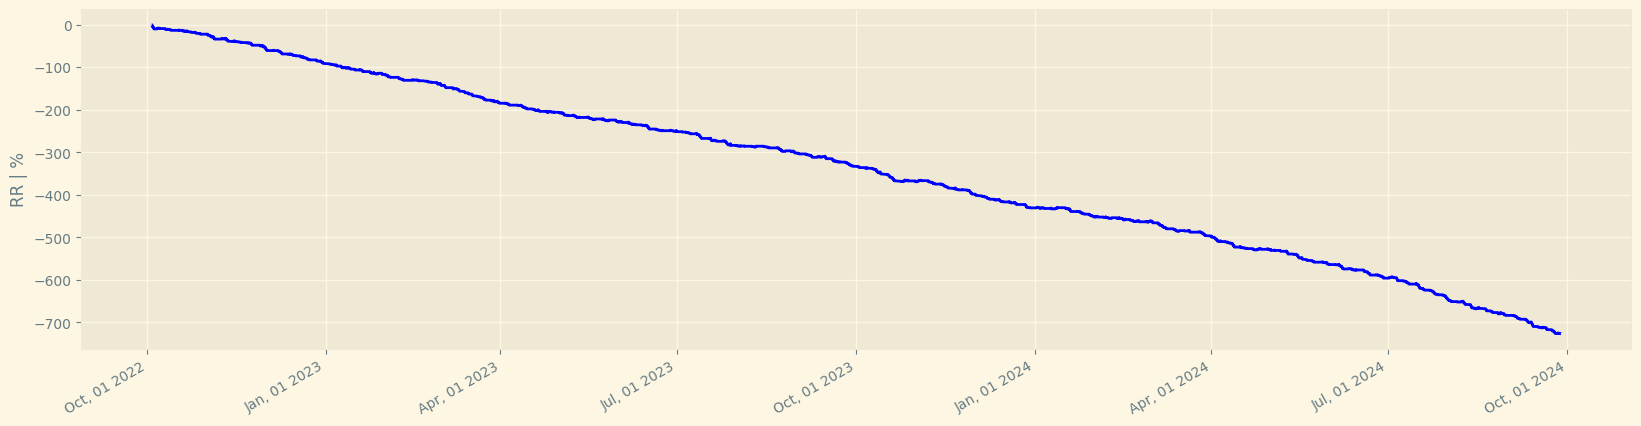

In [202]:
# Plot the Strategy returns
df['Cumulative_PnL'].plot(
        label='Strategy', 
        figsize=(20, 5), 
        color='blue', 
        xlabel='',
        ylabel='RR | %'
    )

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)